In [1]:
from helper_fn import *
import seaborn as sns

## Downloading the following dataframes

1. df
2. df600
3. df_label: PEMAT-labelled dataset.

NOTE: https:// creates problems with word_count distribution.

In [2]:
# NOTE: df should have 56 columns because we don't have labels on actionability, understandability, etc.
df = pd.read_csv("merged_and_cleaned12k.csv", sep = ",").dropna(how = "all").drop(columns = ["Unnamed: 0"])
df600 = pd.read_csv("merged_and_cleaned600.csv", sep = ",").drop(columns = ["Unnamed: 0"])
df_label = pd.read_csv("rawPEMAT.csv", sep = ",").drop(columns = ["Unnamed: 0"])
df_annotate = pd.read_csv("AnnotatedVideoFeatures.csv", sep = ",")

In [3]:
df600 = pd.merge(df600, df_annotate, how = "inner", left_on = "URL", right_on = "id", suffixes = [None, "f2"])

In [4]:
# Load the dictionary of PEMAT. 
# Plan: Work back and forth between the PEMAT raw file (df_label) and the cleaned file (df600).
f = open("PEMAT_dict.pkl","rb")
PEMAT_dict = pickle.load(f)

In [5]:
# Merge videos that appear multiple times under different keywords. 
groupby_column = 'video_id'
aggregate_column = 'keyword'
agg_df = df.groupby(groupby_column).aggregate({aggregate_column: list})
df_alias = df.drop(columns=aggregate_column).set_index(groupby_column)
agg_df = agg_df.join(df_alias).reset_index(groupby_column).drop_duplicates(groupby_column).reset_index(drop=True)
df = agg_df

In [217]:
dfcopy = df.copy()

,video_id,keyword,ARI,FleshReadingEase,Kincaid,active_verb,has_description,id,sentence_count,summary_words,...,channelVideoCount,keyword_decription_cosine,comment_total_words,negative_comment_count,comment_description_cosine,keyword_title_cosine,comment_title_cosine,postive_comment_count,comment_unique_words,neutral_comment_count
0,--3PG0yv7xo,[insulin sensitive],7.80,75.04,6.54,91.00,1.00,--3PG0yv7xo,44.00,0.00,...,270.00,0.24,"1,381.00",5.00,5.68,0.14,1.22,36.00,"1,134.00",5.00
1,--GLJISL-sM,[glycogenolysis],32.95,-24.82,26.66,5.00,1.00,--GLJISL-sM,3.00,0.00,...,121.00,0.16,23.00,0.00,0.11,0.18,0.00,2.00,20.00,0.00
2,--KcUndJ7Tw,[Repaglinide],9.47,48.64,8.96,2.00,1.00,--KcUndJ7Tw,2.00,0.00,...,"1,069.00",0.00,0.00,0.00,0.00,0.21,0.00,0.00,0.00,0.00
3,--P1IWDqESU,[End stage renal disease],11.00,56.28,8.69,5.00,1.00,--P1IWDqESU,5.00,0.00,...,"34,681.00",0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
4,--Zx-67-FfY,[diabetic heart disease],15.32,37.55,14.14,27.00,1.00,--Zx-67-FfY,8.00,0.00,...,"1,269.00",0.04,463.00,1.00,0.53,0.17,0.38,3.00,290.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8958,zxHEWa3J-I4,[glucose test strip],15.71,31.71,13.56,3.00,1.00,zxHEWa3J-I4,2.00,0.00,...,121.00,0.07,0.00,0.00,0.00,0.36,0.00,0.00,0.00,0.00
8959,zxeKsGLpUEg,[pancreatic islet],2.26,187.64,-11.17,0.00,1.00,zxeKsGLpUEg,1.00,0.00,...,"1,025.00",0.00,0.00,0.00,0.00,0.31,0.00,0.00,0.00,0.00
8960,zyP82eAMVrU,[diabetic coma],13.56,77.04,11.21,6.00,1.00,zyP82eAMVrU,1.00,0.00,...,"25,337.00",0.00,0.00,0.00,0.00,0.36,0.00,0.00,0.00,0.00
8961,zz-zF1w2WwY,[glucose tolerance],0.00,0.00,0.00,0.00,0.00,zz-zF1w2WwY,0.00,0.00,...,16.00,0.00,0.00,0.00,0.00,0.61,0.00,0.00,0.00,0.00


# PART 1: Descriptive Statistics

First, I examined the features and classified them into three categories. 
1. Video metadata
2. Video 
3. Usage statistics



**NOTE: See merge_and_cleaned for a description on the PEMAT labels. This is a descriptive statistics on the entire dataset.

## Useful resource
1. ARI: https://en.wikipedia.org/wiki/Automated_readability_index
2. Flesch reading ease:
3. Kincaid (formally titled: Flesch-Kincaid readability). https://readable.com/readability/flesch-reading-ease-flesch-kincaid-grade-level/
4. Cosine similarity: https://www.machinelearningplus.com/nlp/cosine-similarity/

## Appropriate ranges
1. ARI: 1-14
2. Kincaid: 0-19; 
3. Flesch: 0-100.
4. cosine similarity -1 to 1; 

In [7]:
# Checking the summary statistics for each of these features. 
fare = ["min", "max", "median", "mean", "std"]
temp = {}

# Labels
label = ["understand","action", "info"]

# Video metadata
readable = ['ARI', 'FleshReadingEase','Kincaid']

# Derivatives of video metadata
description_d = ["word_unique", "transition_words","summary_words","active_verb", "word_count", "sentence_count"]
keyword = ['keyword_title_cosine', 'keyword_decription_cosine']
channel = ['channelSubscriberCount', "channelViewCount", "channelCommentCount", "channelVideoCount"] # TODO: Log
duration = ["video_duration"] # Is already an integer
license = ["contentLicensed"]

# Miscellaneous
rank = ["rank"]
content = ["contentDefinition", "contentLicensed"]

# Usage statistics (outcome metrics)
like_dislike_view = ["likeCount", "dislikeCount", "viewCount"] # TODO: Log-transform
comment_cosine = ['comment_title_cosine', 'comment_description_cosine']
comment_d = ['commentCount','postive_comment_count','negative_comment_count','neutral_comment_count', 
           "comment_unique_words", "comment_total_words"]

# Group all variables in the dataframe: cateogrical or numerical 
dependent = label
numeric = readable + description_d + keyword + channel + duration + like_dislike_view + comment_cosine + comment_d
categoric = license + content
misc = rank

In [8]:
title = df600["channelTitle"].value_counts()

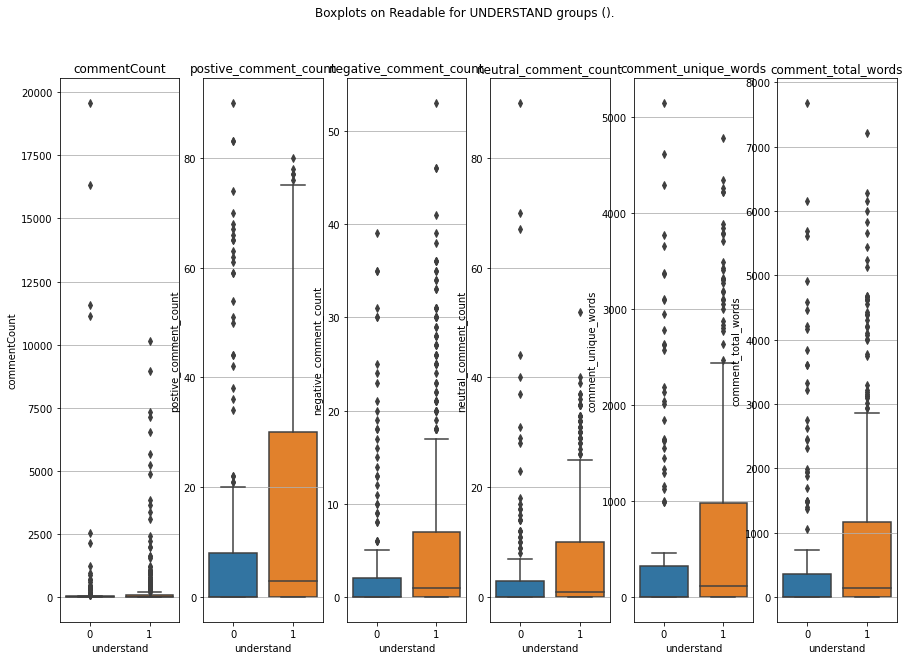

In [9]:
fig = boxplotVisualizer(df600, "understand", feature_lst = comment_d, title = "Readable")

In [10]:
# Summary statistics of Tables created in 2021. 
dependent = "action"
to_save600 = comparisonTable(df600, dependent, numeric).T
to_save600.to_csv("%s_summary.csv" %(dependent))
to_save8900 = summaryStatistics(df, numeric, fare = ["min", "max", "median", "mean", "std"]).T
to_save8900.to_csv("all_summary.csv")

/var/folders/4t/6j0632nj7bv5d1dkqdjmp3000000gn/T/ipykernel_83680/2113748802.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


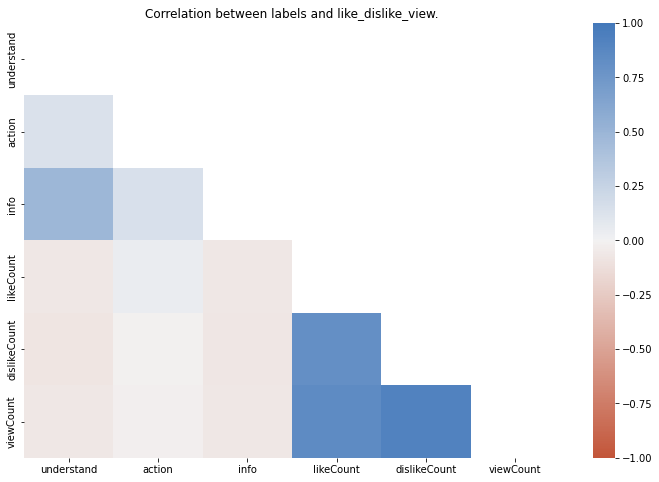

In [11]:
# Plotting heatmap for correlation between two variables and labels
var_lst = ["readable", "description_d", "keyword", "channel", "duration", "like_dislike_view"]
var_lst += ["comment_cosine", "comment_d"]
var = var_lst[5]
title = "label_%s" %(like_dislike_view) + ".png"
cmap = sns.diverging_palette(20, 250, as_cmap=True)
fig, ax = plt.subplots(figsize = (12,8))
corr = df600[label + like_dislike_view].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Building dataframe
ax = sns.heatmap(corr, cmap = cmap, mask=mask, vmin = -1, vmax = 1)
ax.set_title("Correlation between labels and %s." %(var))
fig.savefig(title)

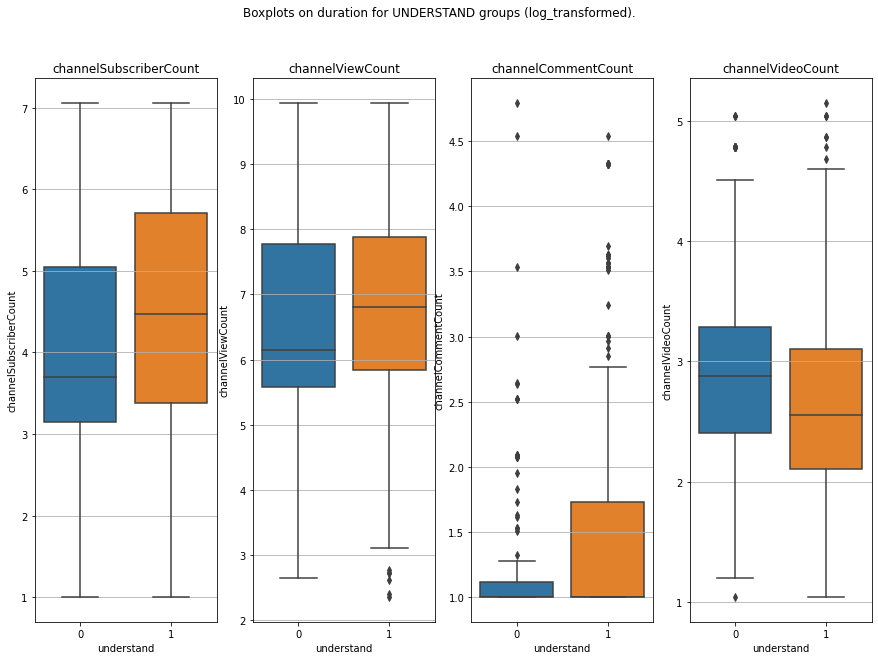

In [12]:
# TODO: Like-dislike/viewCount ratio. 
dep_lst = ["understand", "action", "info"]
dependent = dep_lst[0]

feature_name = "channel"
title = "duration"
fig = boxplotVisualizer(df600, dependent, channel, title = title,
                        log_transform = True)
title = "boxplot_%s_%s" %(dependent,feature_name)
fig.savefig(title)

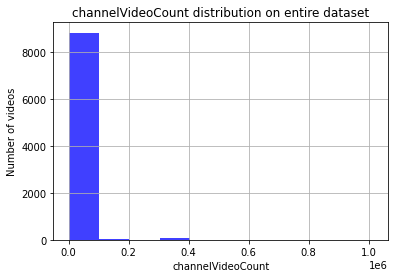

In [13]:
# Perform histogram of the dataset.
var = "channelVideoCount"
entire = True

if entire == True:
    x = df[var]
    name = "entire dataset"
else:
    x = df600[var]
    name = "labelled dataset"
bins = [2**i for i in range(7)]
fig = plt.hist(x, density = False, facecolor='b', alpha=0.75)
plt.xlabel('%s' %(var))
plt.ylabel('Number of videos')
plt.title('%s distribution on %s' %(var,name))
plt.grid(True)

In [11]:
# Check if columns of df600 and df are the same.
# Only difference: video_duration, understand, action, URL, which all appear in other forms already.
for col in df600.columns.tolist():
    if col not in df.columns.tolist():
        print(col)

URL
Duration
info
action
understand
scene_count
object_count
idf2
speech_confidence
text_confidence
sentence_countf2
word_countf2
word_uniquef2
ARIf2
Kincaidf2
Flesch
transition_wordsf2
summary_wordsf2
active_verbf2


# PART 2: Building models
In this part, I used Kincaid as a response variable. The dataset is the miniature 600 versions whereby we have the labels. The logistic regression model is built upon only numerical values. Overall, the accuracy is egregiously high (80%), suggesting that I might overfit?

In [15]:
# Drop the indices with no_info. 
# Why: I have checked the data. These rows contains many NaN.
no_info = np.where(df600["info"].isna() == True)[0].tolist()
no_info += np.where(df600["viewCount"].isna() == True)[0].tolist()
no_count = np.where(np.isfinite(df600["sentence_count"]) == False)[0].tolist()
try:
    df600 = df600.drop(index = no_info+no_count)
    print("Row with no info and no sentence_count successfully dropped")
    df600 = df600.drop(columns = ["Unnamed: 0"])
    print("Dropping unnamed column.")
except:
    print("Columns already dropped")

Row with no info and no sentence_count successfully dropped
Columns already dropped


In [16]:
# Truncate ARI to be from 0-14
ub = 14
lb = 0
truncateColumn(df600, lb, ub, "ARI")

,URL,Duration,info,action,understand,ARI,FleshReadingEase,Kincaid,active_verb,has_description,...,text_confidence,sentence_countf2,word_countf2,word_uniquef2,ARIf2,Kincaidf2,Flesch,transition_wordsf2,summary_wordsf2,active_verbf2
0,-32U9eU1hdM,310,1.00,0,1,14.00,28.51,13.75,59.00,1.00,...,0.87,26,635,311,16.56,16.22,22.30,14,0,81
1,-71ld0iqAq8,602,1.00,0,1,9.06,52.87,8.75,31.00,1.00,...,0.85,36,1241,449,19.28,16.28,39.73,14,0,170
2,-8HmZjScLe0,732,0.00,0,0,14.00,70.67,10.03,42.00,1.00,...,0.79,107,1883,502,5.61,5.03,90.36,21,0,463
3,-Aj5BTnz-v0,559,1.00,1,1,14.00,25.99,13.21,23.00,1.00,...,0.80,79,1861,409,8.87,7.70,81.82,17,0,309
4,-IaysvX1L8U,246,1.00,0,1,12.51,45.13,11.97,16.00,1.00,...,0.96,26,599,282,13.29,13.02,42.78,11,0,104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,zLbAxztnnfE,163,0.00,0,0,14.00,19.81,16.74,77.00,1.00,...,0.90,24,349,166,10.54,10.16,48.09,8,0,39
569,zPdwsCTp4gM,751,1.00,0,1,8.49,65.03,7.58,6.00,1.00,...,1.00,87,1806,650,10.42,9.64,62.89,20,1,301
570,zU-5GcqzHNM,819,1.00,1,1,14.00,62.72,12.56,17.00,1.00,...,0.88,109,1890,650,7.80,7.26,73.93,24,0,364
571,z_3S2_41_FE,300,1.00,0,1,9.27,75.98,7.75,32.00,1.00,...,0.93,61,786,370,5.25,4.72,84.19,13,0,124


# ChannelLevel Analysis

**NOTE: We have removed videos appearing twice under different keywords.**
There are $8,963$ videos, appearing in $5,322$ channels. Interestingly, there are $3,304$ videos with more than $5,000$ views (from now, I call them relevant), appearing in $2,186$ channels. Hence, there are $3,000$ channels responsible for $5,600$ videos (i.e., these channels appear only 1.9 times among many keyword search related to diabetes). 

Findings:
1. Top 1% channel (ranked by number of videos in this dataset) produces $1,276$ (14%) of the videos but only $10%$ of the views. Almost 60% of the videos are created only from 20% of the channels. See the cumulative plot.
2. After top 20%, the remaining videos are created by one channel per one video, as suggested by the slope almost equal to 53/89 (1 video per 1 channel; 53 channel = 1% >> 53 video = 53/89%). 
3. The step-wise nature of the percentView, percentLike, etc. suggests clear outliers. 
My thoughts on viewCount analysis:

1. It's suspicious that their videos appear only once or twice given that we use so many keywords related to diabetes. However, their title is sometimes relevant (yoga video // glyocosis vs glycogenesis ..), but the channelVideoCount looks very sketchy >> If they have many videos, but many of their videos are not related to diabetes, maybe they are not experts on diabetes. 
2. Classifying misinformation based on views is not a great idea, I think. 


In [260]:
df[df["channelTitle"] == "botcaster inc. bot"][["title", "viewCount"]]

,title,viewCount
76,"Medical vocabulary: What does Insulin, Short-A...",4
379,Medical vocabulary: What does Glucagon-Like Pe...,12
537,Medical vocabulary: What does Hyperandrogenism...,20
667,"Medical vocabulary: What does Glycosuria, Rena...",62
754,Medical vocabulary: What does Islets of Langer...,14
1262,Medical vocabulary: What does Glucagon-Like Pe...,19
1311,Medical vocabulary: What does Amylin Receptor ...,22
1538,Medical vocabulary: What does Linagliptin mean,50
1706,Medical vocabulary: What does Cambium mean,1
1770,Medical vocabulary: What does Colesevelam Hydr...,66


In [263]:
# Identify videos with more views than 1% of the total views. 
var = "viewCount"
thresh = sum(df[var])*0.01
list3 = df[df[var] > thresh][["viewCount","likeCount","dislikeCount", "title"]].index
df[df[var] > thresh][["title",'channelTitle', "keyword", "viewCount","rank"]]

,title,channelTitle,keyword,viewCount,rank
569,First Of The Year (Equinox) - Skrillex [OFFICIAL],Skrillex,[starlix],369970829,1
821,THESE GLASSES CURED MY COLORBLINDNESS!,Logan Paul Vlogs,[adult blindness],24097435,12
1016,Banda El Recodo De Cruz Lizárraga - Consecuenc...,BandaElRecodoVEVO,[ACTOS],144488302,2
1284,The Most UNEXPECTED Auditions EVER!,MusicTalentNow,[ACTOS],46618529,46
2425,Miguelito tiene novia - Morandé con Compañía 2016,MEGA Oficial,[miglitol],21256698,5
3265,"Earth, Wind & Fire - Let's Groove",EarthWindandFireVEVO,[Toujeo],82532868,35
4016,Frank Medrano - Superhuman Bodyweight Workout ...,Frank Medrano,[body weight],40268477,3
5648,Miguelito aprende zumba con sensual instructor...,MEGA Oficial,[miglitol],20146716,6
8940,MC Kevinho - Tô Apaixonado Nessa Mina (KondZilla),Canal KondZilla,[Nesina],226092625,11


In [275]:
# Checking outlier videos and their properties
dominator = list3
try:
    df = df.drop(index = dominator)
except:
    print("Outliers already removed.")
    
index = 87
temp = df[df["channelTitle"].isin([channel for channel in channel_toplst[index+1] 
                                           if channel not in channel_toplst[index]])]

Outliers already removed.


In [280]:
# Plot of cumulative values for like_dislike_view. \n",
cumulative = []
for var in like_dislike_view:
    temp = [(sum(df[df["channelTitle"].isin(channel_top)][var])/sum(df[var]))*100
                      for channel_top in channel_toplst] # The Top X channels account for how many views\n",
    cumulative.append(temp)
percentLike = cumulative[0]
percentDislike = cumulative[1]
percentView = cumulative[2]

# The Top X channels account for how many views
percentVideo = [(df[df["channelTitle"].isin(channel_top)].shape[0]/df.shape[0])*100
                for channel_top in channel_toplst]

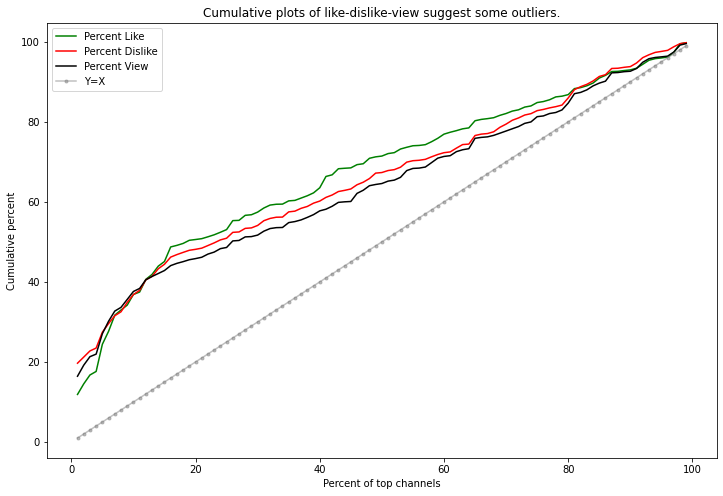

In [281]:
# Figure 1: Cumulative plots of like-dislike-view suggest some outliers
# NOTE: Polarizing? Keyword: Adult blindness. Title: THESE GLASSES CURED MY COLORBLINDNESS! by Logan Paul. 
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(1,100,1), percentLike, label = "Percent Like", color = "green")
ax.plot(np.arange(1,100,1), percentDislike, label = "Percent Dislike", color = "red")
ax.plot(np.arange(1,100,1), percentView, label = "Percent View", color = "black")
ax.plot(np.arange(1,100,1),np.arange(1,100,1), marker = ".",label = "Y=X", color = "gray", alpha = 0.5)
plt.title("Cumulative plots of like-dislike-view suggest some outliers.")
ax.set_xlabel('Percent of top channels')
ax.set_ylabel('Cumulative percent')
ax.legend()
fig.savefig("cdf_preRemoved.png")

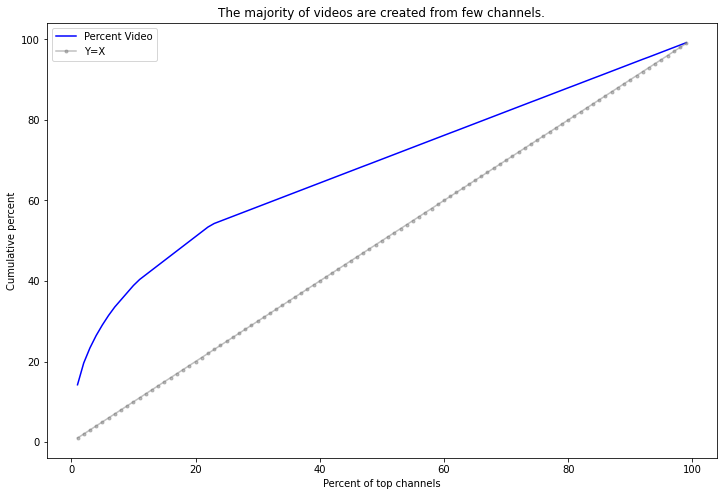

In [282]:
# Figure 2: The majority of videos are created from few channels
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(1,100,1), percentVideo, label = "Percent Video", color = "blue")
ax.plot(np.arange(1,100,1),np.arange(1,100,1), marker = ".",label = "Y=X", color = "gray", alpha = 0.5)
plt.title("The majority of videos are created from few channels.")
ax.set_xlabel('Percent of top channels')
ax.set_ylabel('Cumulative percent')
ax.legend()
fig.savefig("cdf_nvideo_preRemoved.png")

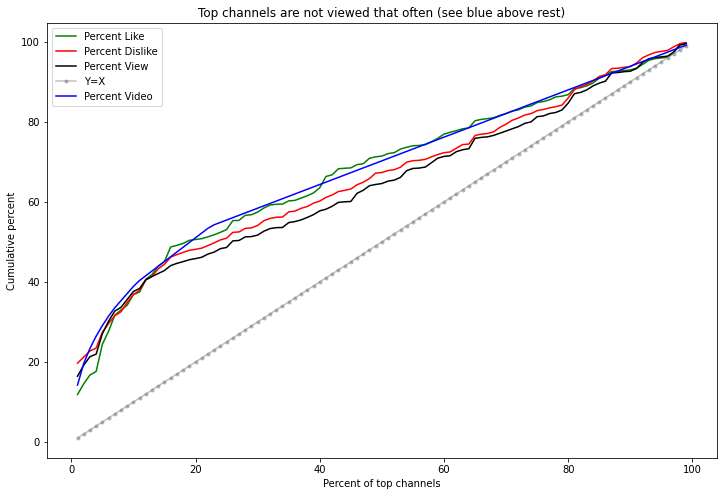

In [284]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(1,100,1), percentLike, label = "Percent Like", color = "green")
ax.plot(np.arange(1,100,1), percentDislike, label = "Percent Dislike", color = "red")
ax.plot(np.arange(1,100,1), percentView, label = "Percent View", color = "black")
ax.plot(np.arange(1,100,1),np.arange(1,100,1), marker = ".",label = "Y=X", color = "gray", alpha = 0.5)
ax.plot(np.arange(1,100,1), percentVideo, label = "Percent Video", color = "blue")
plt.title("Top channels are not viewed that often (see blue above rest)")
ax.set_xlabel('Percent of top channels')
ax.set_ylabel('Cumulative percent')
ax.legend()
fig.savefig("cdf_all_afterRemoved.png")

In [316]:
# What about rank? Are videos from top channels recommended more often?
prop = 0.1
nchannel = len(df["channelTitle"].value_counts())
top_channel = df["channelTitle"].value_counts().index[:int(nchannel*prop)]
bottom_channel = df["channelTitle"].value_counts().index[int(nchannel*(1-prop)):]

5313

In [313]:
df[df["channelTitle"].isin(topp_channel)]["rank"].mean()

24.248807631160574

In [314]:
df[df["channelTitle"].isin(bottomp_channel)]["rank"].mean()

25.864864864864863